### Ethnicolr: NC Voter Registration Name Model (Race only)

We build a separate model that only predicts the race_code and takes out 'U', again assuming it to be 'missing at random.'

In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.5.0
2.5.1


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
NGRAMS = (2, 3)
SAMPLE = 1000000
EPOCHS = 15

# NC voter
df = pd.read_csv('../dataverse_files/nc_voter_reg/nc_voter_name_gender_race_ethnic_age.csv', usecols=['last_name', 'first_name', 'race_code'], nrows=SAMPLE * 2)
df.dropna(subset=['first_name', 'last_name'], inplace=True)

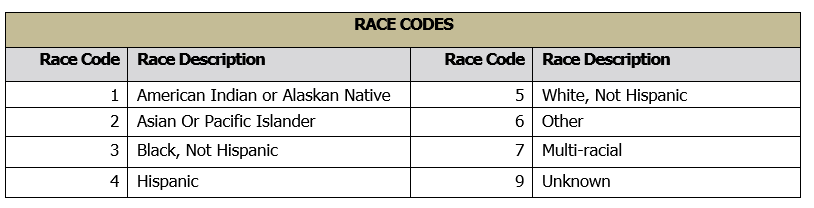

### Drop U and UN from race and ethnic.

In [4]:
df.drop(df[df.race_code=='U'].index, inplace=True)
df

,last_name,first_name,race_code
0,AABEL,EVELYN,W
1,AARON,CHRISTINA,W
2,AARON,CLAUDIA,W
3,AARON,JAMES,W
4,AARON,NATHAN,W
...,...,...,...
1999995,LEAK,ANTHONY,B
1999996,LEAK,ANTOINETTE,B
1999997,LEAK,BETTY,B
1999998,LEAK,BILLY,B


In [5]:
df.groupby(['race_code']).size()

race_code
A      16176
B     376291
I       7761
M      12004
O      41580
W    1482050
dtype: int64

In [6]:
df['race'] = df['race_code']
df

,last_name,first_name,race_code,race
0,AABEL,EVELYN,W,W
1,AARON,CHRISTINA,W,W
2,AARON,CLAUDIA,W,W
3,AARON,JAMES,W,W
4,AARON,NATHAN,W,W
...,...,...,...,...
1999995,LEAK,ANTHONY,B,B
1999996,LEAK,ANTOINETTE,B,B
1999997,LEAK,BETTY,B,B
1999998,LEAK,BILLY,B,B


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.groupby(['race']).size()

race
A     15262
B    293173
I      7356
M     11844
O     39305
W    991209
dtype: int64

In [9]:
max_size = df['race'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('race'):
    lst.append(group.sample(max_size-len(group), replace=True))
odf = pd.concat(lst)
odf

,last_name,first_name,race_code,race
0,AABEL,EVELYN,W,W
1,AARON,CHRISTINA,W,W
2,AARON,CLAUDIA,W,W
3,AARON,JAMES,W,W
4,AARON,NATHAN,W,W
...,...,...,...,...
1241522,SAEZ,MAIAELISE,O,O
703967,CORONADO,ANDREA,O,O
1104084,HILARIO,REYNALDO,O,O
1390458,BARNES,ROSE,O,O


In [10]:
odf.groupby('race').agg({'first_name': 'count'})

,first_name
race,
A,991209
B,991209
I,991209
M,991209
O,991209
W,991209


In [11]:
sdf = odf.sample(SAMPLE, random_state=21)
sdf

,last_name,first_name,race_code,race
425701,CLAYTON,VANESSA,B,B
1123015,RAMASWAMI,JOSEPH,A,A
1877347,BAKER,CHRISTAIN,W,W
1905838,CATES,JEAN,B,B
1900420,BUT JOHNSON,KANHA,A,A
...,...,...,...,...
1518449,MATTOCK,DAVID PAUL,O,O
1079251,YANG,CASEY,A,A
1563299,REBELS,BEONNA,I,I
1065723,SYNN,AUSTIN,A,A


In [12]:
# Additional features
sdf['first_name'] = sdf.first_name.str.title()
sdf['last_name'] = sdf.last_name.str.title()

rdf = sdf.groupby('race').agg({'first_name': 'count'})
rdf

,first_name
race,
A,166890
B,166431
I,166462
M,166516
O,166334
W,167367


In [13]:
rdf.to_csv('../models/nc_voter_reg/lstm/nc_name_race_only.csv', columns=[])

## Preprocessing the input data

In [14]:
%%time
# concat last name and first name
sdf['last_name_first_name'] = sdf['last_name'] + ' ' + sdf['first_name']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=10, ngram_range=NGRAMS, lowercase=False) 
a = vect.fit_transform(sdf.last_name_first_name)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)

num_words = 12861
CPU times: user 19min 18s, sys: 1.84 s, total: 19min 20s
Wall time: 19min 21s


In [15]:
vocab

{'Cl': 1204,
 'la': 8327,
 'ay': 5104,
 'yt': 12579,
 'to': 11256,
 'on': 9721,
 'n ': 8978,
 ' V': 322,
 'Va': 4067,
 'an': 4862,
 'ne': 9107,
 'es': 6373,
 'ss': 10956,
 'sa': 10745,
 'Cla': 1205,
 'lay': 8353,
 'ayt': 5127,
 'yto': 12587,
 'ton': 11272,
 'on ': 9722,
 'n V': 9000,
 ' Va': 323,
 'Van': 4076,
 'ane': 4869,
 'nes': 9128,
 'ess': 6394,
 'ssa': 10959,
 'Ra': 3414,
 'am': 4836,
 'ma': 8726,
 'as': 4974,
 'sw': 11019,
 'wa': 12047,
 'mi': 8810,
 'i ': 7357,
 ' J': 153,
 'Jo': 2333,
 'os': 9825,
 'se': 10794,
 'ep': 6324,
 'ph': 10060,
 'Ram': 3429,
 'ama': 4839,
 'mas': 8745,
 'asw': 4999,
 'swa': 11020,
 'wam': 12061,
 'ami': 4847,
 'mi ': 8811,
 'i J': 7367,
 ' Jo': 163,
 'Jos': 2352,
 'ose': 9832,
 'sep': 10813,
 'eph': 6331,
 'Ba': 981,
 'ak': 4788,
 'ke': 8092,
 'er': 6346,
 'r ': 10232,
 ' C': 43,
 'Ch': 1177,
 'hr': 7263,
 'ri': 10418,
 'is': 7748,
 'st': 10974,
 'ta': 11094,
 'ai': 4741,
 'in': 7649,
 'Bak': 993,
 'ake': 4793,
 'ker': 8108,
 'er ': 6347,
 'r C': 10

In [16]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    ngrams = (ngramRange[0], ngramRange[1] + 1)
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [17]:
%%time
def find_ngrams(text, ngrams):
    a = range_ngrams(text, ngrams)
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.last_name_first_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.race.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Max feature len = 37, Avg. feature len = 12
CPU times: user 1min 5s, sys: 233 ms, total: 1min 6s
Wall time: 1min 6s


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [18]:
'''The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 25 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

800000 train sequences
200000 test sequences
Pad sequences (samples x time)
X_train shape: (800000, 25)
X_test shape: (200000, 25)
6 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (800000, 6)
y_test shape: (200000, 6)


In [19]:
print('Build model...')

if True:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
if False:
    embedding_vecor_length = 50
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 32)            411552    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 494,758
Trainable params: 494,758
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
%%time
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/15
22500/22500 [==============================] - 578s 25ms/step - loss: 1.4661 - accuracy: 0.4093 - val_loss: 1.3347 - val_accuracy: 0.4744
Epoch 2/15
22500/22500 [==============================] - 532s 24ms/step - loss: 1.3276 - accuracy: 0.4784 - val_loss: 1.2466 - val_accuracy: 0.5131
Epoch 3/15
22500/22500 [==============================] - 530s 24ms/step - loss: 1.2617 - accuracy: 0.5050 - val_loss: 1.1727 - val_accuracy: 0.5455
Epoch 4/15
22500/22500 [==============================] - 529s 24ms/step - loss: 1.2199 - accuracy: 0.5231 - val_loss: 1.1346 - val_accuracy: 0.5607
Epoch 5/15
22500/22500 [==============================] - 556s 25ms/step - loss: 1.1950 - accuracy: 0.5340 - val_loss: 1.1061 - val_accuracy: 0.5736
Epoch 6/15
22500/22500 [==============================] - 537s 24ms/step - loss: 1.1802 - accuracy: 0.5407 - val_loss: 1.0792 - val_accuracy: 0.5854
Epoch 7/15
22500/22500 [==============================] - 534s 24ms/step - loss: 1.1635 - accurac

In [21]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.9971374869346619
Test accuracy: 0.6245399713516235


## Confusion Matrix

In [22]:
p = model.predict(X_test, verbose=2) # to predict probability
y_pred = np.argmax(p, axis=-1)
target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

6250/6250 - 27s
              precision    recall  f1-score   support

           A       0.81      0.77      0.79     33378
           B       0.52      0.51      0.51     33286
           I       0.71      0.91      0.80     33292
           M       0.53      0.60      0.56     33303
           O       0.69      0.48      0.57     33267
           W       0.49      0.48      0.48     33474

    accuracy                           0.62    200000
   macro avg       0.63      0.62      0.62    200000
weighted avg       0.63      0.62      0.62    200000



In [23]:
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(conf_mat)

[[25832  1334   745  1299  1898  2270]
 [  586 16935  4170  5608   696  5291]
 [   92   844 30403   848   187   918]
 [  497  4464  1722 19908  2731  3981]
 [ 4109  3082  1560  4602 15868  4046]
 [  786  5923  4234  5088  1481 15962]]


In [24]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

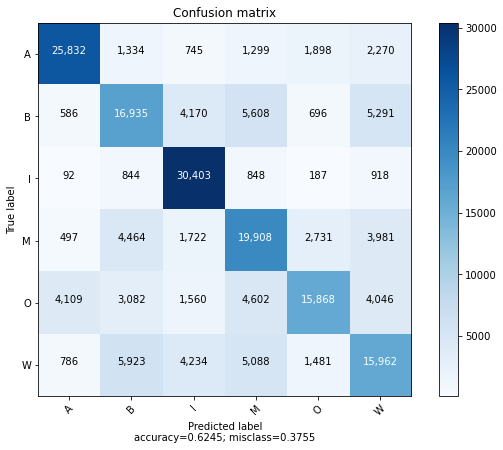

In [25]:
plot_confusion_matrix(conf_mat, target_names, normalize=False)

### Save model

In [26]:
model.save('../models/nc_voter_reg/lstm/nc_voter_name_race_lstm_oversample.h5')

In [27]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('../models/nc_voter_reg/lstm/nc_voter_name_race_vocab_oversample.csv', index=False, encoding='utf-8')